# 语义分割和数据集

Pascal VOC2012 最重要的语义分割数据集之一

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                          '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

下面将read_voc_images函数定义为将所有输入的图像和标签读入内存

In [3]:
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    # 函数定义：
    # voc_dir: VOC数据集的根目录路径
    # is_train: 布尔值，True表示读取训练集，False表示读取验证集
    
    # 构造包含图像文件名的txt文件路径
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    # os.path.join(): 用于拼接文件路径，自动处理不同操作系统的路径分隔符
    # 如果is_train=True，读取train.txt；否则读取val.txt
    # 这些txt文件包含了用于训练/验证的图像文件名列表
    
    # 设置图像读取模式为RGB（红绿蓝三通道彩色图像）
    mode = torchvision.io.image.ImageReadMode.RGB
    # ImageReadMode.RGB: 确保图像以RGB格式读取，即使原图可能是其他格式
    
    # 打开并读取txt文件中的图像文件名
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    # with open(): 安全地打开文件，使用完毕后自动关闭
    # f.read(): 读取整个文件内容为一个字符串
    # .split(): 将字符串按空白字符（空格、换行符等）分割成列表
    # 结果：images是一个包含所有图像文件名（不含扩展名）的列表
    
    # 初始化两个空列表，用于存储图像特征和标签
    features, labels = [], []
    # features: 存储原始图像数据（输入）
    # labels: 存储分割标注图像（目标输出）
    
    # 遍历每个图像文件名，读取对应的图像和标签
    for i, fname in enumerate(images):
        # enumerate(): 同时获取索引i和值fname
        # i: 当前图像的索引（0, 1, 2, ...）
        # fname: 当前图像的文件名（不含扩展名）
        
        # 读取原始图像（JPEG格式）并添加到features列表
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        # torchvision.io.read_image(): 读取图像文件，返回张量格式
        # os.path.join(): 拼接完整的图像文件路径
        # f'{fname}.jpg': 格式化字符串，给文件名添加.jpg扩展名
        # VOC数据集中，原始图像存储在JPEGImages文件夹中
        
        # 读取分割标注图像（PNG格式）并添加到labels列表
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
        # SegmentationClass文件夹：包含分割标注的PNG图像
        # 标注图像中每个像素的值代表该像素属于哪个类别
        # mode参数：确保标注图像也以RGB模式读取
    
    # 返回读取到的所有图像特征和对应的标签
    return features, labels
    # features: 包含所有原始图像张量的列表
    # labels: 包含所有分割标注张量的列表

# 调用函数读取训练集数据
train_features, train_labels = read_voc_images(voc_dir, True)

下面我们绘制前5个输入图像及其标签。 在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。

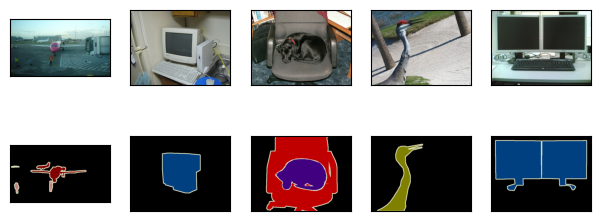

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
# PyTorch训练时用的格式
# tensor_img.shape  # torch.Size([3, 224, 224])
# matplotlib显示需要的格式  
# display_img.shape  # (224, 224, 3)
# 所以需要转换
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

接下来，我们列举RGB颜色值和类名。

In [5]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

通过上面定义的两个常量，我们可以方便地查找标签中每个像素的类索引。 我们定义了voc_colormap2label函数来构建从上述RGB颜色值到类别索引的映射，而voc_label_indices函数将RGB值映射到在Pascal VOC2012数据集中的类别索引。

```
问题是什么？
分割图是彩色的，但机器学习需要数字！
假设我们只有3个类别：
背景 = 黑色(0,0,0)
人 = 红色(255,0,0)
车 = 绿色(0,255,0)

具体例子
原始分割图（彩色）：
像素1: (0,0,0)     # 黑色
像素2: (255,0,0)   # 红色  
像素3: (0,255,0)   # 绿色
像素4: (255,0,0)   # 红色
机器需要的格式（数字）：
像素1: 0  # 背景类别
像素2: 1  # 人类别
像素3: 2  # 车类别  
像素4: 1  # 人类别
两个函数的作用
第一个函数：建立"颜色→数字"的字典
python# 相当于建立这样的映射关系：
字典 = {
    黑色(0,0,0): 0,      # 背景
    红色(255,0,0): 1,    # 人
    绿色(0,255,0): 2     # 车
}
第二个函数：查字典，把颜色转成数字
# 输入彩色图片，输出数字图片
彩色图 = [(0,0,0), (255,0,0), (0,255,0), (255,0,0)]
数字图 = [0, 1, 2, 1]  # 根据字典转换
为什么这样做？
因为机器学习算法不能直接处理"红色"、"绿色"这种概念，只能处理数字0、1、2
这两个函数就是做这个颜色→数字的翻译工作

In [6]:
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    # 创建一个长度为256³的零张量，用于存储RGB到类别索引的映射
    # 256³ = 16,777,216，覆盖所有可能的RGB组合
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    
    # 遍历VOC预定义的颜色映射表
    for i, colormap in enumerate(VOC_COLORMAP):
        # 将RGB三元组压缩成一个唯一整数作为索引
        # 公式：(R * 256 + G) * 256 + B
        # 相当于将RGB看作256进制数转为10进制
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
                                        # ↑ 这个复杂索引对应RGB颜色    ↑ 类别索引(0,1,2,...)
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    # 将tensor从(C,H,W)转为(H,W,C)，再转为numpy数组
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    
    # 对每个像素应用RGB到整数的转换公式
    # colormap[:, :, 0] 是所有像素的R值
    # colormap[:, :, 1] 是所有像素的G值  
    # colormap[:, :, 2] 是所有像素的B值
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 
           + colormap[:, :, 2])
    
    # 使用映射表将RGB整数索引转换为类别索引
    return colormap2label[idx]

例如，在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0。

In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

预处理数据

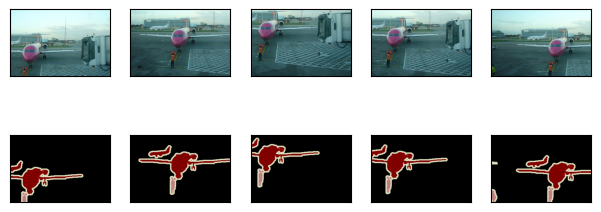

In [8]:
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    # 使用torchvision的RandomCrop获取随机裁剪的参数（位置坐标）
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    # 对原始图像(feature)进行裁剪
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 对标签图像(label)使用相同的裁剪参数，保证对应关系
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []  # 创建空列表，用于存储裁剪后的图像
# 循环n次，生成n组随机裁剪
for _ in range(n):
    # 对第一张训练图像进行随机裁剪，裁剪尺寸为200×300
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
# 转换图像格式：从(C,H,W)转为(H,W,C)，便于显示
imgs = [img.permute(1, 2, 0) for img in imgs]
# 显示图像：imgs[::2]是所有原始图像，imgs[1::2]是所有标签图像
# imgs[::2]：第0,2,4...个元素（原始图像）
# imgs[1::2]：第1,3,5...个元素（标签图像）
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

自定义语义分割数据集类

我们通过继承高级API提供的Dataset类，自定义了一个语义分割数据集类VOCSegDataset。 通过实现__getitem__函数，我们可以任意访问数据集中索引为idx的输入图像及其每个像素的类别索引。 由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的filter函数移除掉。 此外，我们还定义了normalize_image函数，从而对输入图像的RGB三个通道的值分别做标准化。

In [11]:
#类定义和初始化方法
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        # 定义图像标准化参数（ImageNet预训练模型的标准参数）
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # RGB三通道的均值
            std=[0.229, 0.224, 0.225])   # RGB三通道的标准差
        
        # 保存裁剪尺寸参数
        self.crop_size = crop_size
        
        # 读取VOC数据集的原始图像和标签图像
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        
        # 对原始图像进行过滤和标准化处理
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        
        # 对标签图像进行过滤（去掉太小的图像）
        self.labels = self.filter(labels)
        
        # 建立颜色到类别索引的映射表
        self.colormap2label = voc_colormap2label()
        
        # 打印加载的样本数量
        print('read ' + str(len(self.features)) + ' examples')

    #图像标准化方法
    def normalize_image(self, img):
        # 将图像像素值从[0,255]范围转换到[0,1]范围，再进行标准化
        return self.transform(img.float() / 255)
        # img.float() / 255：转为浮点数并归一化到[0,1]
        # self.transform：应用均值和标准差标准化
    
    #图像过滤方法
    def filter(self, imgs):
        # 过滤掉尺寸太小的图像，确保能够进行有效裁剪
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and  # 图像高度 >= 目标裁剪高度
            img.shape[2] >= self.crop_size[1])]    # 图像宽度 >= 目标裁剪宽度
        # img.shape = (C, H, W)，所以shape[1]是高度，shape[2]是宽度
    
    #获取单个样本方法
    def __getitem__(self, idx):
        # 对指定索引的图像对进行随机裁剪
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)  # *解包crop_size元组
        
        # 返回处理后的特征图像和转换为类别索引的标签图像
        return (feature, voc_label_indices(label, self.colormap2label))
        # feature：标准化后的原始图像
        # voc_label_indices(label, ...)：将彩色标签转为数字类别索引
    
    #获取数据集长度方法
    def __len__(self):
        # 返回数据集中的样本总数
        return len(self.features)

读取数据集

我们通过自定义的VOCSegDataset类来分别创建训练集和测试集的实例。 假设我们指定随机裁剪的输出图像的形状为320×480，下面我们可以查看训练集和测试集所保留的样本个数。

In [12]:
# 定义裁剪尺寸：高320像素，宽480像素
crop_size = (320, 480)

# 创建训练数据集实例
voc_train = VOCSegDataset(True, crop_size, voc_dir)
# True表示加载训练集
# crop_size是随机裁剪的目标尺寸
# voc_dir是VOC数据集的路径

# 创建测试数据集实例
voc_test = VOCSegDataset(False, crop_size, voc_dir)
# False表示加载测试集（验证集）

read 1114 examples
read 1078 examples


设批量大小为64，我们定义训练集的迭代器。 打印第一个小批量的形状会发现：与图像分类或目标检测不同，这里的标签是一个三维数组。

In [ ]:
# 设置批次大小为64
batch_size = 64

# 创建训练数据加载器
train_iter = torch.utils.data.DataLoader(
    voc_train,                               # 数据集实例
    batch_size,                              # 批次大小：64
    shuffle=True,                            # 随机打乱数据顺序
    drop_last=True,                          # 丢弃最后不足batch_size的批次
    num_workers=d2l.get_dataloader_workers() # 多进程加载数据的工作线程数
)

# 测试DataLoader的输出形状
for X, Y in train_iter:
    print(X.shape)  # 打印特征图像的形状：应该是[64, 3, 320, 480]
    print(Y.shape)  # 打印标签图像的形状：应该是[64, 320, 480]
    break           # 只看第一个批次就退出循环

整合所有组件-封装成函数

最后，我们定义以下load_data_voc函数来下载并读取Pascal VOC2012语义分割数据集。 它返回训练集和测试集的数据迭代器。

In [ ]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    
    # 下载并解压VOC2012数据集到指定目录
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    # 'voc2012'：数据集标识符
    # 解压到：./VOCdevkit/VOC2012/目录下
    
    # 获取数据加载的工作线程数（根据CPU核心数自动设置）
    num_workers = d2l.get_dataloader_workers()
    
    # 创建训练数据加载器
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir),  # 训练数据集
        batch_size,                               # 批次大小
        shuffle=True,                             # 训练时需要随机打乱
        drop_last=True,                           # 丢弃不完整批次
        num_workers=num_workers                   # 多线程加载
    )
    
    # 创建测试数据加载器
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), # 测试数据集
        batch_size,                               # 批次大小
        drop_last=True,                           # 丢弃不完整批次
        num_workers=num_workers                   # 多线程加载
        # 注意：测试时不需要shuffle=True
    )
    
    # 返回训练和测试数据加载器
    return train_iter, test_iter